# Introduction

This notebook presents **Transer Learning** on **ResNet50** applied to [Oxford VGG Flowers 17](http://www.robots.ox.ac.uk/~vgg/data/flowers/) dataset.

**Contents**

* [VGG Flowers 17 Dataset](#VGG-Flowers-17-Dataset)
* [Transfer - No Data Aug](#Transfer---No-Data-Aug)
* [Transfer - With Data Aug](#Transfer---With-Data-Aug)

# Imports

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
with tf.Session(config=config):
    pass  # init sessin with allow_growth

# VGG Flowers 17 Dataset

In [3]:
dataset_location = '../Datasets/vgg-flowers-17/'

In [4]:
datafile = os.path.join(dataset_location, '17flowers.npz')
if not os.path.isfile(datafile):
    print('Run StanfordDogs.ipynb notebook first!')
    raise

In [5]:
npzfile = np.load(datafile)
train_images_raw = npzfile['train_images']
train_labels_raw = npzfile['train_labels']
valid_images_raw = npzfile['valid_images']
valid_labels_raw = npzfile['valid_labels']

In [6]:
train_images = tf.keras.applications.resnet50.preprocess_input(train_images_raw.astype(np.float32))
valid_images = tf.keras.applications.resnet50.preprocess_input(valid_images_raw.astype(np.float32))
print('train_images.shape:', train_images.shape)
print('valid_images.shape:', valid_images.shape)
print('valid_images:\n', valid_images[0,:,:,0].round())  # first image, red channel

train_images.shape: (1190, 224, 224, 3)
valid_images.shape: (170, 224, 224, 3)
valid_images:
 [[-102. -104. -103. ... -104. -102. -104.]
 [-101. -103. -103. ... -104.  -97.  -93.]
 [-102. -104. -103. ...  -85.  -73.  -55.]
 ...
 [ -57.  -58.  -60. ...  -79.  -82.  -83.]
 [ -54.  -58.  -61. ...  -83.  -79.  -76.]
 [ -63.  -68.  -70. ...  -85.  -82.  -79.]]


In [7]:
train_labels = tf.keras.utils.to_categorical(train_labels_raw)
valid_labels = tf.keras.utils.to_categorical(valid_labels_raw)
print('train_labels.shape:', train_labels.shape)
print('valid_labels.shape:', valid_labels.shape)
print('valid_labels:\n', valid_labels)

train_labels.shape: (1190, 17)
valid_labels.shape: (170, 17)
valid_labels:
 [[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]


# Transfer - No Data Aug

Load pretrained ResNet50 without top layers

In [8]:
resnet50 = tf.keras.applications.resnet50.ResNet50(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

Precompute resnet features for all our data. We are training only output classifier, so there is no point passing same images through same convolution layers over and over again. Istead we pre-compute resnet ouputs once per each image and use that to train our classifier.

In [9]:
train_features = resnet50.predict(train_images, batch_size=250)
valid_features = resnet50.predict(valid_images, batch_size=250)
train_features = train_features.squeeze()
valid_features = valid_features.squeeze()
print('train_features.shape:', train_features.shape)

train_features.shape: (1190, 2048)


Create model for classifier

In [29]:
from tensorflow.keras.layers import Dense, Dropout

model = tf.keras.Sequential()
model.add(Dense(units=64, activation='elu', input_dim=2048))
model.add(Dropout(0.5))
model.add(Dense(units=64, activation='elu'))
model.add(Dropout(0.5))
model.add(Dense(units=17, activation='softmax'))
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0001),
              loss='categorical_crossentropy', metrics=['accuracy'])

Train model

In [30]:
hist = model.fit(train_features, train_labels, batch_size=32, epochs=100,
                 validation_data=(valid_features, valid_labels), verbose=0)

Final results

In [31]:
tloss, tacc = model.evaluate(train_features, train_labels, batch_size=34, verbose=0)
vloss, vacc = model.evaluate(valid_features, valid_labels, batch_size=34, verbose=0)
print(f'tr loss: {tloss:5.3f}    tr acc: {100*tacc:4.1f}%    va loss: {vloss:5.3f}     va acc: {100*vacc:4.1f}%')

tr loss: 0.000    tr acc: 100.0%    va loss: 0.340     va acc: 88.2%


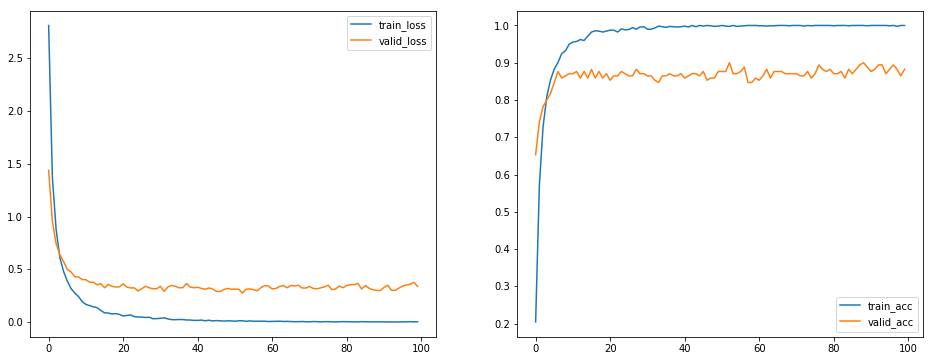

In [32]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=[16,6])
ax1.plot(hist.history['loss'], label='train_loss')
ax1.plot(hist.history['val_loss'], label='valid_loss')
ax1.legend()
ax2.plot(hist.history['acc'], label='train_acc')
ax2.plot(hist.history['val_acc'], label='valid_acc')
ax2.legend();

As you can see we are overfitting pretty badly

# Transfer - With Data Aug

Setup keras data augumentation

In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_data_gen = ImageDataGenerator(
    rotation_range=10,       # random rotation degrees
    width_shift_range=0.1,   # random shift 10%
    height_shift_range=0.1,
    horizontal_flip=True)

Show original image

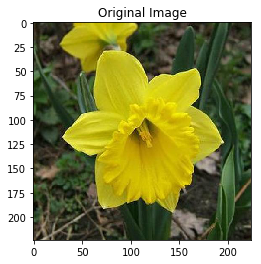

In [16]:
plt.imshow(train_images_raw[7].astype(int))
plt.title('Original Image');

Show couple augumented images

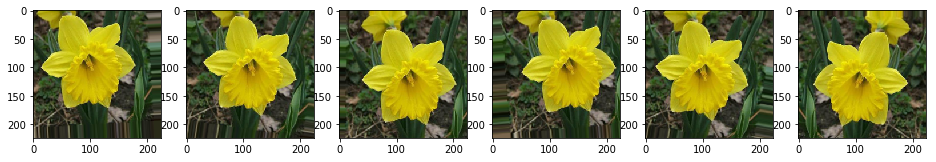

In [17]:
fig, axes = plt.subplots(nrows=1, ncols=6, figsize=[16, 9])
for i, x_img in enumerate(img_data_gen.flow(train_images_raw[7:8], batch_size=1)):
    axes[i].imshow(x_img.astype(int)[0])
    if i >= len(axes)-1:
        break

Produce augumented dataset of both images and matching labels

In [18]:
images_list = []
labels_list = []

for i in range(10):
    for imgs, labels in img_data_gen.flow(train_images, train_labels, batch_size=len(train_images)):
        images_list.extend(imgs)
        labels_list.extend(labels)
        break
    
augumented_images = np.array(images_list)
augumented_labels = np.array(labels_list)

print('augumented_images.shape:', augumented_images.shape)
print('augumented_labels.shape:', augumented_labels.shape)

augumented_images.shape: (11900, 224, 224, 3)
augumented_labels.shape: (11900, 17)


Load pre-trained ResNet50, this is same as previous paragraph

In [19]:
resnet50 = tf.keras.applications.resnet50.ResNet50(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

Pre-calculate resnet ouput features for augumented dataset

In [21]:
augumented_features = resnet50.predict(augumented_images, batch_size=250)
augumented_features = augumented_features.squeeze()
print('augumented_features.shape:', augumented_features.shape)

augumented_features.shape: (11900, 2048)


Pre-calculate resnet outputs for validation set

In [22]:
valid_features = resnet50.predict(valid_images, batch_size=250)
valid_features = valid_features.squeeze()
print('valid_features.shape:', valid_features.shape)

valid_features.shape: (170, 2048)


Create model, thid is the same as in previous section

In [45]:
from tensorflow.keras.layers import Dense, Dropout

model = tf.keras.Sequential()
model.add(Dense(units=256, activation='elu', input_dim=2048))
model.add(Dropout(0.5))
model.add(Dense(units=256, activation='elu'))
model.add(Dropout(0.5))
model.add(Dense(units=17, activation='softmax'))
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0001),
              loss='categorical_crossentropy', metrics=['accuracy'])

Train model - because dataset is 10x larger reduce amount of epochs by 10, so we keep nb interations constant

In [46]:
hist = model.fit(augumented_features, augumented_labels, batch_size=34, epochs=10,
                 validation_data=(valid_features, valid_labels), verbose=0)

Final results

In [47]:
tloss, tacc = model.evaluate(augumented_features, augumented_labels, batch_size=34, verbose=0)
vloss, vacc = model.evaluate(valid_features, valid_labels, batch_size=34, verbose=0)
print(f'tr loss: {tloss:5.3f}    tr acc: {100*tacc:4.1f}%    va loss: {vloss:5.3f}     va acc: {100*vacc:4.1f}%')

tr loss: 0.001    tr acc: 100.0%    va loss: 0.257     va acc: 91.2%


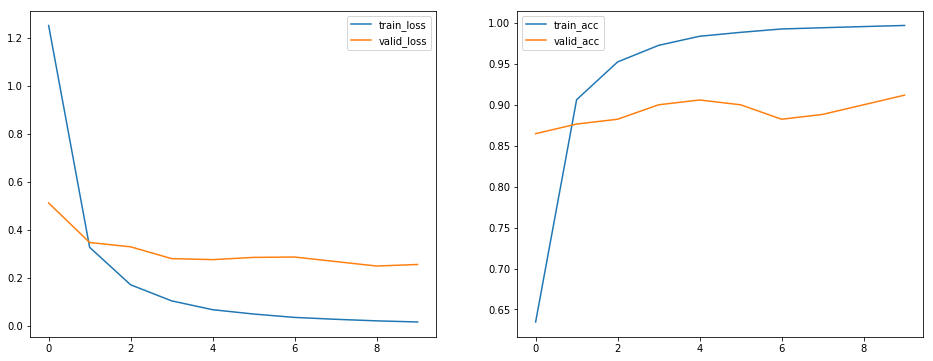

In [48]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=[16,6])
ax1.plot(hist.history['loss'], label='train_loss')
ax1.plot(hist.history['val_loss'], label='valid_loss')
ax1.legend()
ax2.plot(hist.history['acc'], label='train_acc')
ax2.plot(hist.history['val_acc'], label='valid_acc')
ax2.legend();